# Demo: Gamma mixture model

This notebook implements one of the experiments outlined in https://biaslab.github.io/publication/mp-based-inference-in-gmm/.

## Load packages

In [1]:
using Rocket, ReactiveMP, GraphPPL
using Distributions, Random
using Parameters
using StatsPlots
import ProgressMeter

In [2]:
# create custom structure for model parameters for simplicity
struct GammaMixtureModelParameters
    nmixtures   # number of mixtures
    priors_as   # tuple of priors for variable a
    priors_bs   # tuple of priors for variable b
    prior_s     # prior of variable s
end

## Model specification

In [3]:
@model [ default_factorisation = MeanField() ] function gamma_mixture_model(nobservations, parameters::GammaMixtureModelParameters)

    # fetch information from struct
    nmixtures = parameters.nmixtures
    priors_as = parameters.priors_as
    priors_bs = parameters.priors_bs
    prior_s   = parameters.prior_s

    # set prior on global selection variable
    s ~ Dirichlet(probvec(prior_s))

    # allocate vectors of random variables
    as = randomvar(nmixtures, prod_constraint = ProdGeneric(), form_constraint = PointMassFormConstraint(starting_point = (args...) -> ones(1)))
    bs = randomvar(nmixtures)

    # set priors on variables of mixtures
    for i in 1:nmixtures
        as[i] ~ GammaShapeRate(shape(priors_as[i]), rate(priors_as[i]))
        bs[i] ~ GammaShapeRate(shape(priors_bs[i]), rate(priors_bs[i]))
    end

    # introduce random variables for local selection variables and data
    z = randomvar(nobservations)
    y = datavar(Float64, nobservations)

    # convert vector to tuples for proper functioning of GammaMixture node
    tas = tuple(as...)
    tbs = tuple(bs...)

    # specify local selection variable and data generating process
    for i in 1:nobservations
        z[i] ~ Categorical(s)
        y[i] ~ GammaMixture(z[i], tas, tbs)
    end

    # return random variables
    return s, as, bs, z, y
    
end

gamma_mixture_model (generic function with 1 method)

In [4]:
function gamma_mixture_inference(data, niterations, parameters)

    # extract information from parameters
    @unpack nmixtures = parameters
    @unpack priors_as, priors_bs, prior_s = parameters

    # fetch number of observations and number of features
    nobservations = length(data)

    # create model
    model, (s, as, bs, z, y) = gamma_mixture_model(model_options(limit_stack_depth = 100), nobservations, parameters);

    # allocate marginals
    mswitch   = keep(Marginal)
    mselector = buffer(Marginal, nobservations)
    mas       = buffer(Marginal, nmixtures)
    mbs       = buffer(Marginal, nmixtures)
    fe        = ScoreActor(Float64)

    # subscribe to marginals
    switch_sub    = subscribe!(getmarginal(s), mswitch)
    selectors_sub = subscribe!(getmarginals(z), mselector)
    as_sub        = subscribe!(getmarginals(as), mas)
    bs_sub        = subscribe!(getmarginals(bs), mbs)
    fe_sub        = subscribe!(score(Float64, BetheFreeEnergy(), model), fe)

    # set initial marginals
    setmarginal!(s, prior_s)
    setmarginals!(z, vague(Categorical, nmixtures))
    setmarginals!(bs, GammaShapeRate(1.0, 1.0))

    # update data (and therefore perform inference)
    ProgressMeter.@showprogress for i in 1:niterations
        update!(y, data)
    end

    # fetch and return output
    output = map(getvalues, (mswitch, mselector, mas, mbs, fe))
    return (output[1], [ output[2] ], [ output[3] ], [ output[4] ], output[5])
    
end

gamma_mixture_inference (generic function with 1 method)

In [5]:
# specify seed and number of data points
rng = MersenneTwister(43)
n_samples = 2500

# specify parameters of mixture model that generates the data
# Note that mixture components have exactly the same means
mixtures  = [ Gamma(9.0, inv(27.0)), Gamma(90.0, inv(270.0)) ]
nmixtures = length(mixtures)
mixing    = rand(rng, nmixtures)
mixing    = mixing ./ sum(mixing)
mixture   = MixtureModel(mixtures, mixing)

# generate data set
dataset = rand(rng, mixture, n_samples);

In [10]:
# specify priors of probabilistic model
# NOTE: As the means of the mixtures "collide", we specify informative prior for selector variable
nmixtures = 2
priors = GammaMixtureModelParameters(
    nmixtures,                                                  # number of mixtures
    [Gamma(1.0, 0.1), Gamma(1.0, 1.0)],                         # priors on variables a
    [GammaShapeRate(10.0, 2.0), GammaShapeRate(1.0, 3.0)],      # priors on variables b
    Dirichlet(1e3*mixing)                                       # prior on variable s
)

# perform probabilistic inference
mswitch, mselector, mas, mbs, fe = gamma_mixture_inference(dataset, 250, priors);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


In [11]:
# extract inferred parameters
_as, _bs = mean.(mas[end]), mean.(mbs[end])
_dists   = map(g -> Gamma(g[1], inv(g[2])), zip(_as, _bs))
_mixing = mean(mswitch[end])

# create model from inferred parameters
_mixture   = MixtureModel(_dists, _mixing);

In [12]:
# report on outcome of inference
println("Generated means: $(mean(mixtures[1])) and $(mean(mixtures[2]))")
println("Inferred means: $(mean(_dists[1])) and $(mean(_dists[2]))")
println("========")
println("Generated mixing: $(mixing)")
println("Inferred mixing: $(_mixing)")

Generated means: 0.3333333333333333 and 0.33333333333333337
Inferred means: 0.33291988991693044 and 0.3341329583716068
Generated mixing: [0.18923488676601088, 0.8107651132339891]
Inferred mixing: [0.11345674868480075, 0.8865432513151992]


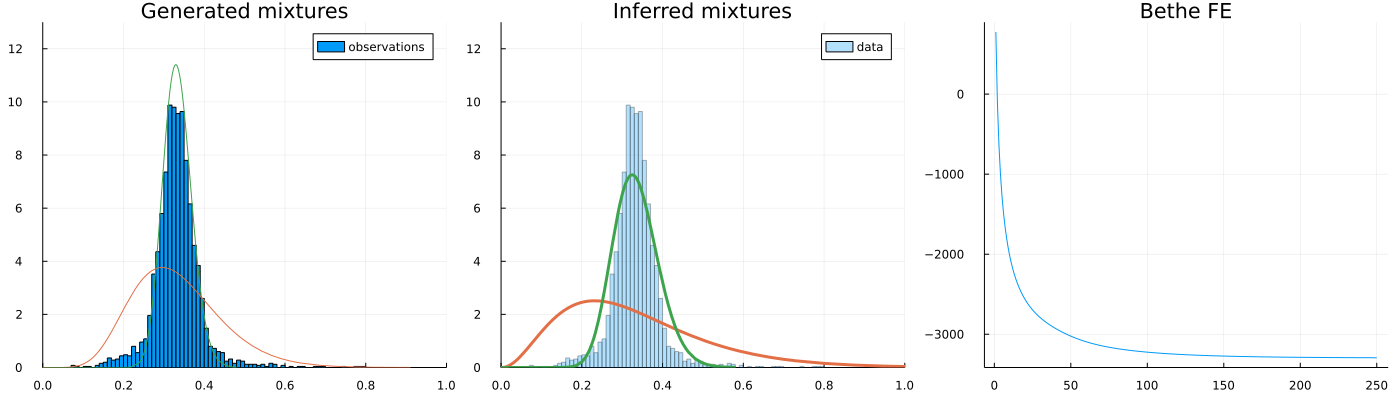

In [13]:
# plot results
p1 = histogram(dataset, ylim = (0, 13), xlim = (0, 1), normalize=:pdf, label="observations")
p1 = plot!(mixture, label=false, title="Generated mixtures")

p2 = histogram(dataset, ylim = (0, 13), xlim = (0, 1), normalize=:pdf, label="data", opacity=0.3)
p2 = plot!(_mixture, label=false, title="Inferred mixtures", linewidth=3.0)

# evaluate the convergence of the algorithm by monitoring the BFE
p3 = plot(fe, label=false, xlabel="iterations", title="Bethe FE")

plot(p1, p2, p3, layout = @layout([ a b c ]), size=(1400, 400))